In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
path = untar_data(URLs.CAMVID)

In [9]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [11]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_05850.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f03180.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008820.png')]

In [13]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_02340_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01710_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f00120_P.png')]

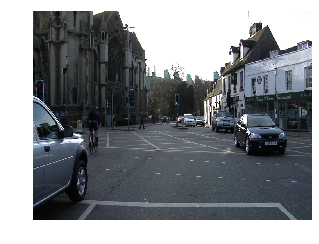

In [16]:
img_f = fnames[13]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [0]:
mask = open_mask(get_y_fn(img_f))

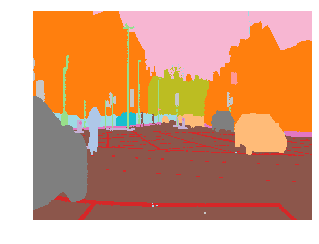

In [20]:
mask.show(figsize=(5, 5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:])

In [22]:
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [24]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
bs = 8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file(path/'valid.txt')
      .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=src_size//2, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input_, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input_.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = [acc_camvid]

In [0]:
wd = 1e-2

In [32]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 107346294.52it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


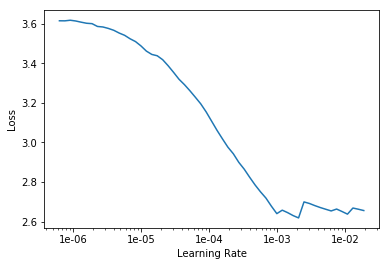

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(10, slice(1e-4))

epoch,train_loss,valid_loss,acc_camvid,time
0,2.136465,1.169388,0.711887,01:33
1,1.211806,0.712749,0.829187,01:29
2,0.842117,0.612366,0.833563,01:29
3,0.686574,0.499275,0.864405,01:28
4,0.594365,0.466214,0.869425,01:28
5,0.540976,0.475141,0.870887,01:28
6,0.492525,0.415228,0.879052,01:28
7,0.458856,0.390192,0.887396,01:28
8,0.438525,0.381867,0.889910,01:28
9,0.427790,0.382646,0.890828,01:28


In [0]:
learn.save('stage-1-small')

In [0]:
learn.load('stage-1-small');

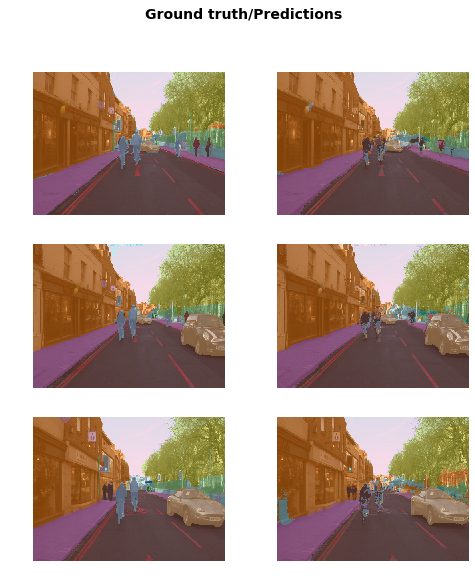

In [36]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


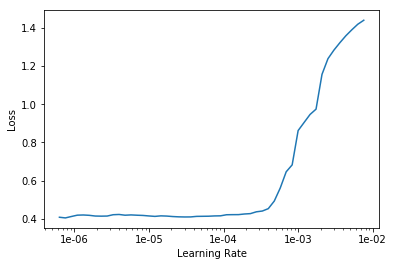

In [38]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(12, slice(5e-6, 1e-4/5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.424540,0.381832,0.889578,01:32
1,0.421909,0.381755,0.890337,01:32
2,0.418633,0.375936,0.892272,01:32
3,0.415952,0.367334,0.897351,01:32
4,0.401937,0.351951,0.901114,01:32
5,0.390670,0.368135,0.894181,01:32
6,0.378660,0.346906,0.901769,01:32
7,0.364227,0.338168,0.903218,01:32
8,0.353752,0.336499,0.903339,01:32
9,0.352804,0.335869,0.904432,01:32


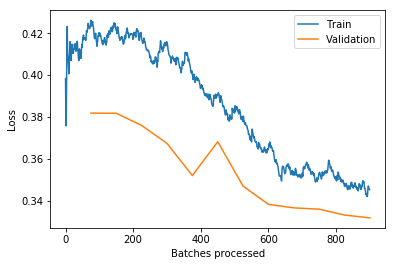

In [45]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-small')

In [47]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 14299MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2-small');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


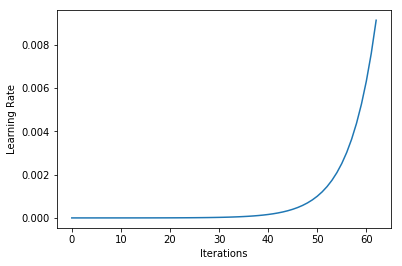

In [51]:
learn.lr_find()

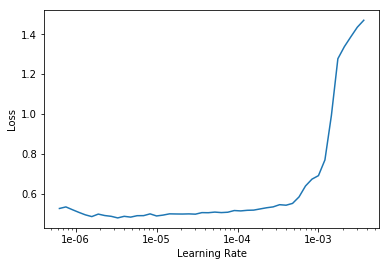

In [52]:
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(10, slice(1e-4))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.460337,0.380681,0.888546,05:40
1,0.480878,0.413141,0.879349,06:12
2,0.484159,0.358285,0.897972,06:12
3,0.424383,0.345613,0.900765,06:11
4,0.384036,0.313895,0.909592,06:11
5,0.358102,0.302347,0.915743,06:11
6,0.319113,0.295898,0.915647,06:11
7,0.292420,0.289354,0.916804,06:11
8,0.279226,0.292993,0.915174,06:11
9,0.270204,0.300185,0.913994,06:11


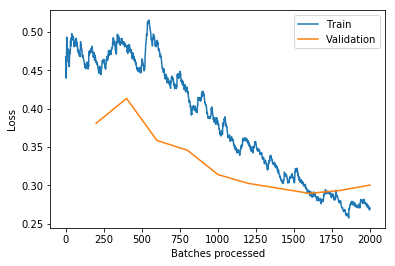

In [55]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

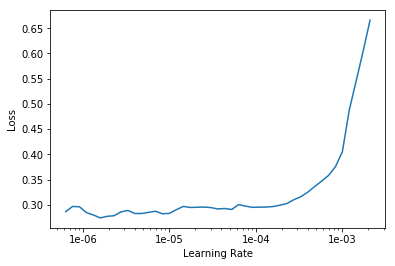

In [58]:
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(10, slice(6e-6, 1e-4/5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.277222,0.284711,0.918219,06:25
1,0.270174,0.288562,0.915513,06:24
2,0.271761,0.283283,0.918173,06:24
3,0.257585,0.263393,0.924889,06:24
4,0.242261,0.271952,0.921393,06:24
5,0.236966,0.292367,0.914785,06:25
6,0.234329,0.297565,0.913943,06:25
7,0.234085,0.263819,0.923781,06:25
8,0.221237,0.275846,0.920317,06:24
9,0.231627,0.277623,0.920112,06:25


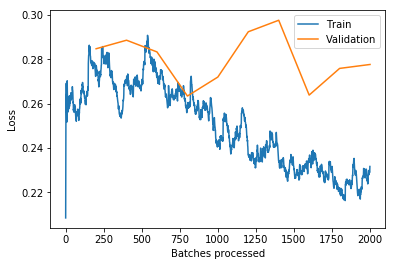

In [60]:
learn.recorder.plot_losses()

We should probably retrain the model with a lower numer of epochs since the model seems to overfit a bit.